In [31]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import xml.etree.ElementTree as ET

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012/'

In [74]:
class VOC2012Dataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224,224)):
        super(VOC2012Dataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        #self.data = pd.read_csv(os.path.join(root_dir, "%s.xml" % mode))
        self.annotations_dir = os.path.join(root_dir, "Annotations")
        self.images_dir = os.path.join(root_dir, "JPEGImages")
        
        # os.listdir returns list in arbitrary order
        self.image_names = os.listdir(self.images_dir)
        self.image_names = [image.rstrip('.jpg') for image in self.image_names]
        
        self.voc_dict = {
                        'person':0, 'bird':1, 'cat':2, 'cow':3, 'dog':4, 
                        'horse':5, 'sheep':6, 'aeroplane':7, 'bicycle':8,
                        'boat':9, 'bus':10, 'car':11, 'motorbike':12, 'train':13, 
                        'bottle':14, 'chair':15, 'diningtable':16, 
                        'pottedplant':17, 'sofa':18, 'tvmonitor':19
                        }
        
        
    def __len__(self):
        return len(self.image_names)

    def __repr__(self):
        return "VOC2012Dataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        # Get file paths for image and annotation (label)
        img_path = os.path.join(self.images_dir, \
                                "%s.jpg" % self.image_names[idx])
        lbl_path = os.path.join(self.annotations_dir, \
                                "%s.xml" % self.image_names[idx])   
        #print(lbl_path)
        #print(self.image_names)
        #print(img_path)
        #print(self.images_dir)
        
        # Get objects and bounding boxes from annotations
        lbl_tree = ET.parse(lbl_path)
        objs = []
        
        img_width = 0
        img_height = 0
        for obj in lbl_tree.iter(tag='size'):
            img_width = int(obj.find('width').text)
            img_height = int(obj.find('height').text)
        
        for obj in lbl_tree.iter(tag='object'):
            name = obj.find('name').text
            for box in obj.iter(tag='bndbox'):
                xmax = int(box.find('xmax').text)
                xmin = int(box.find('xmin').text)
                ymax = int(box.find('ymax').text)
                ymin = int(box.find('ymin').text)
                
                xmax = int(xmax * (self.image_size[0] / img_width))
                xmin = int(xmin * (self.image_size[0] / img_width))
                ymax = int(ymax * (self.image_size[1] / img_height))
                ymin = int(ymin * (self.image_size[1] / img_height))

                xcenter = int((xmax+xmin)/2)
                ycenter = int((ymax+ymin)/2)
                width = int(xmax-xmin)
                height = int(ymax-ymin)
                
                attr = {
                    'name' : self.voc_dict[name],
                    'xcenter' : xcenter/self.image_size[0],
                    'ycenter' : ycenter/self.image_size[1],
                    'width'   : width/self.image_size[0],
                    'height'  : height/self.image_size[1]
                }
                objs.append(attr)
        
        
        # Open and normalize the image
        img = Image.open(img_path).convert('RGB')
        #img = img.crop([0, 0, self.image_size[0], self.image_size[1]])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])
        
        x = transform(img)
        d = objs
        return x, d

    def number_of_classes(self):
        #return self.data['class'].max() + 1
        # TODO: make more flexible
        return 20

tensor([[[ 0.3647,  0.3725,  0.3569,  ..., -0.1922, -0.2392, -0.2314],
         [ 0.3725,  0.3725,  0.3647,  ..., -0.1843, -0.2235, -0.2471],
         [ 0.3804,  0.3804,  0.3725,  ..., -0.1686, -0.2000, -0.2314],
         ...,
         [ 0.3882,  0.3882,  0.3804,  ..., -0.4275, -0.3961, -0.3882],
         [ 0.3333,  0.3255,  0.3647,  ..., -0.3961, -0.3490, -0.3490],
         [ 0.4431,  0.4039,  0.3490,  ..., -0.3882, -0.4118, -0.3333]],

        [[ 0.5686,  0.5765,  0.5843,  ..., -0.1686, -0.1922, -0.2078],
         [ 0.5765,  0.5765,  0.5922,  ..., -0.1451, -0.1529, -0.1686],
         [ 0.5843,  0.5843,  0.6000,  ..., -0.0824, -0.0902, -0.1216],
         ...,
         [ 0.3255,  0.4196,  0.4118,  ..., -0.2235, -0.2000, -0.2235],
         [ 0.2863,  0.3961,  0.4510,  ..., -0.2235, -0.2471, -0.2706],
         [ 0.4353,  0.4118,  0.3647,  ..., -0.1843, -0.2314, -0.3176]],

        [[ 0.8275,  0.8353,  0.8353,  ..., -0.2627, -0.3176, -0.2706],
         [ 0.8353,  0.8353,  0.8431,  ..., -0

<IPython.core.display.Javascript object>


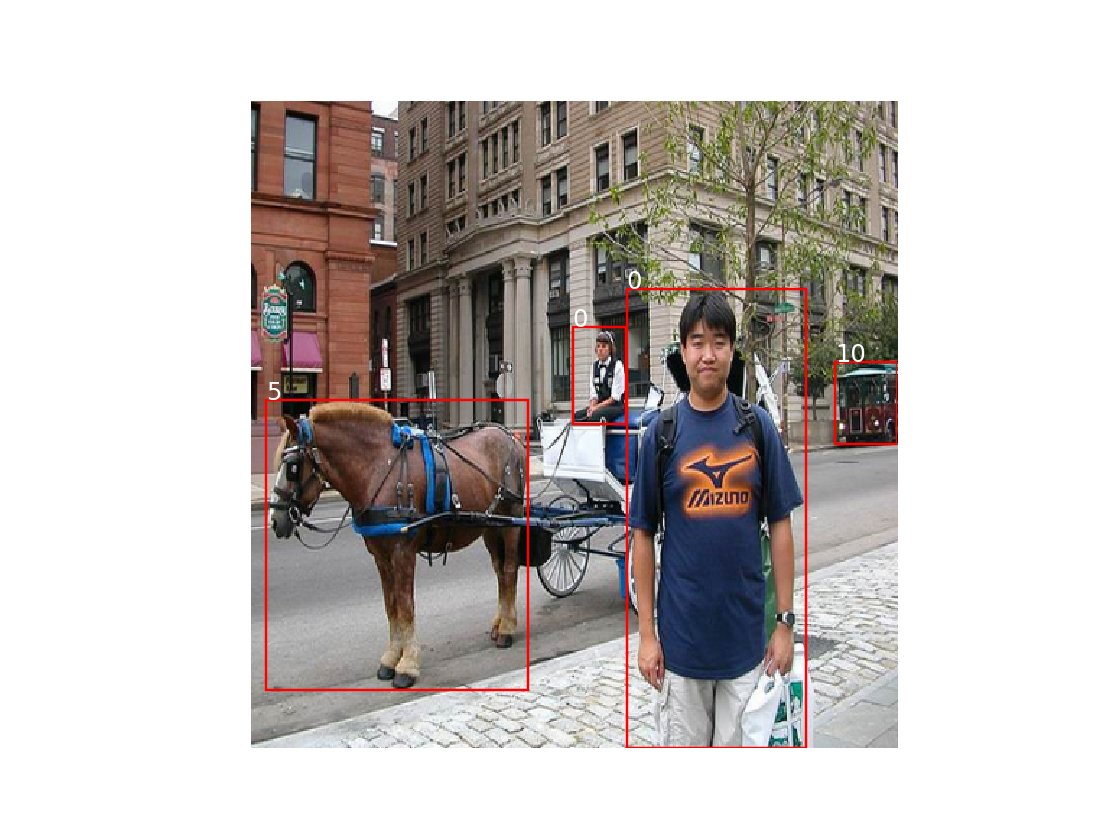

[{'name': 0, 'xcenter': 0.49776785714285715, 'ycenter': 0.41517857142857145, 'width': 0.421875, 'height': 0.8258928571428571}]


In [78]:
def myimshow(image, ax=plt):
    ax.cla()
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis( 'off' )
    return h

train_set = VOC2012Dataset(dataset_root_dir, image_size=(448,448))
x = train_set[9]
#print(x[0])
myimshow(x[0])
print(x[1])

In [94]:
def myimshow_with_bbox(image_with_annot, ax=plt):
    ax.cla()
    image = image_with_annot[0]
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis( 'off' )
    for i in range(len(image_with_annot[1])):
        name = image_with_annot[1][i]['name']
        xcenter = image_with_annot[1][i]['xcenter']
        ycenter = image_with_annot[1][i]['ycenter']
        width = image_with_annot[1][i]['width']
        height = image_with_annot[1][i]['height']
        xmin = (xcenter - width/2)*448
        ymin = (ycenter - height/2)*448
        xmax = (xcenter + width/2)*448
        ymax = (ycenter + height/2)*448
        rect = patches.Rectangle((xmin, ymin), \
                                 xmax - xmin, ymax - ymin, \
                                 linewidth=1,edgecolor='r',facecolor='none')
        plt.gca().add_patch(rect)
        ax.text(xmin, ymin, str(name), color='white')
        #ax.add_patch(rect)
        #ax.show()
    return h

In [95]:
x = train_set[3500]
myimshow_with_bbox(x)

In [69]:
#x = x[0]
x[:,0:30,0:] = 0
myimshow(x)
torch.zeros(20)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1]:
import nntools as nt

class NNRegressor(nt.NeuralNetwork):
    def __init__(self, B=2, C=20, S=7):
        super(NNRegressor, self).__init__()
        self.B = B
        self.C = C
        self.S = S
        
    def criterion(self, y, d):
        # This should take the prediction y (which contains the encoded prediction for the input image)
        # and get the loss, using the ground truth bounding boxes d
        
        # y should be a SxSx(B*5+C) tensor
        B = self.B
        C = self.C
        S = self.S
        
        box_width = 1 / S
        box_height = 1 / S
        
        lambda_coord = 5
        lambda_noobj = 0.5
        
        
        ## Classification Loss        
        class_loss = 0
        for ground_box_i in range(length(d)):
            dd = d[ground_box_i]
            for i in range(S):
                for j in range(S):
                    # calculate pixel range of this box
                    box_x = box_width * i
                    box_y = box_height * j
                    # Check if object appears in this box, if not then skip
                    #if d.xcenter > box_x and d.xcenter <= box_x+box_width and d.ycenter > box_y and d.ycenter <= d.ycenter+box_height:
                    left = int(dd['xcenter'] - d['width']/2)
                    right = int(dd['xcenter'] + d['width']/2)
                    top = int(dd['ycenter'] - d['height']/2)
                    bottom = int(dd['ycenter'] - d['height']/2)
                    
                    # Next line not needed, because this should happen if any object is detected, not just by this box
                    # Well... maybe you do need it
                    if (box_x+box_width < left) or (box_x > right) or (box_y+box_height < top) or (box_y > bottom):
                        continue
                    
                    class_probs = y[i,j,10:]
                    true_class_probs = torch.zeors(C)
                    ground_class = d['name']
                    true_class_probs[ground_class] = 1
                    class_diff = class_probs - true_class_probs
                    class_diff = class_diff * class_diff
                    class_sum = torch.sum(class_diff)
                    class_loss = class_loss + class_sum
                    
                
        ## Localization Loss
        loc_loss = 0
        for ground_box_i in range(legnth(d)):
            dd = d[ground_box_i]
            for i in range(S):
                for j in range(S):
                    # calculate pixel range of this box
                    box_x = box_width * i
                    box_y = box_height * j
                    # Check if box is responsible for this object, if not then skip
                    if not(d['xcenter'] > box_x and d['xcenter'] <= box_x+box_width and d['ycenter'] > box_y and d['ycenter'] <= ['ycenter']+box_height):
                        continue
                    
                    # Figure out which of bbox prediction is responsible for the object
                    bestk = 0
                    bestIOU = 0
                    for k in range(B):
                        left = int(dd['xcenter'] - d['width']/2)
                        right = int(dd['xcenter'] + d['width']/2)
                        top = int(dd['ycenter'] - d['height']/2)
                        bottom = int(dd['ycenter'] - d['height']/2)
                        
                        small_x = max(box_x, left)
                        small_y = max(box_y, top)
                        big_x = min(box_x+box_width, right)
                        big_y = min(box_y+box_height, bottom)
                        
                        intersect = (big_x - small_x) * (big_y - small_y)
                        union = ((right-left) * (bottom-top)) + (box_width * box_height) - intersect
                        
                        iou = intersect/union
                        if iou > bestIOU:
                            bestIOU = iou
                            bestk = bestk
                    
                    pred_dims = y[i,j,(5*k):(5*k+4)]
                    coord_loss = lambda_coord*((pred_dims[0] - dd['xcenter'])**2 + (pred_dims[1] - dd['ycenter'])**2)
                    dim_loss = lambda_coord*((pred_dims[2]**(0.5) - dd['width']**(0.5))**2 + (pred_dims[3]**(0.5) - dd['height']**(0.5))**2)
                    
                    loc_loss = loc_loss + coord_loss + dim_loss
        
        
        ## Confidence Loss
        conf_loss = 0
        for ground_box_i in range(length(d)):
            dd = d[ground_box_i]
            for i in range(S):
                for j in range(S):
                    # calculate pixel range of this box
                    box_x = box_width * i
                    box_y = box_height * j
                    # Check if box is responsible for this object, and use appropriate function
                    if (d['xcenter'] > box_x and d['xcenter'] <= box_x+box_width and d['ycenter'] > box_y and d['ycenter'] <= ['ycenter']+box_height):
                        # Figure out which of bbox prediction is responsible for the object
                        bestk = 0
                        bestIOU = 0
                        for k in range(B):
                            left = int(dd['xcenter'] - d['width']/2)
                            right = int(dd['xcenter'] + d['width']/2)
                            top = int(dd['ycenter'] - d['height']/2)
                            bottom = int(dd['ycenter'] - d['height']/2)
                        
                            small_x = max(box_x, left)
                            small_y = max(box_y, top)
                            big_x = min(box_x+box_width, right)
                            big_y = min(box_y+box_height, bottom)
                        
                            intersect = (big_x - small_x) * (big_y - small_y)
                            union = ((right-left) * (bottom-top)) + (box_width * box_height) - intersect
                        
                            iou = intersect/union
                            if iou > bestIOU:
                                bestIOU = iou
                                bestk = bestk
                            
                        for k in range(B):
                            if k == bestk:
                                conf_loss = conf_loss + (y[i,j,(5*k+4)] - 1)**2
                            else:
                                conf_loss = conf_loss + lambda_noobj*(y[i,j,(5*k+4)] - 1)**2
                    
        return class_loss + loc_loss + conf_loss

In [3]:
def weights_init(m):
    if type(m) in [nn.Conv2d, nn.Linear]:
        m.weight.data = random_weight(m.weight.data.size())
        m.bias.data = zero_weight(m.bias.data.size())

class YoloCNN(NNRegressor):
        
    def __init__(self):
        super(YoloCNN, self).__init__()
        self.network = nn.Sequential(        
            ## All convolutional layers use Leaky ReLU except the last FC layer
            ## All convolutional layers use batch normalization
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2, padding=0),
        
            nn.Conv2d(32, 192, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2, padding=0),
        
            nn.Conv2d(96, 128, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2, padding=0),
        
            nn.Conv2d(256, 256, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2, padding=0),
        
            nn.Conv2d(512, 512, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, 1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1, stride=2),
            nn.LeakyReLU(0.1),
        
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            
            ) # End Sequential object
        
        self.network.apply(weights_init)
        
        self.fc = nn.Sequential(
            nn.Linear(50176,4096),
            nn.Linear(4096,1470)
            )
                    
    def forward(self, x):
        y = self.network(x)
        y = self.fc(y)
        
        y = y.view(-1,7,7,30)
        return y

In [5]:
class YoloStatsManager(nt.StatsManager):
    def __init__(self):
        super(YoloStatsManager, self).__init__()
        
    def init(self):
        super(YoloStatsManager, self).init()

    def accumulate(self, loss, x, y, d):
        super(YoloStatsManager, self).accumulate(loss, x, y, d)
        
    def summarize(self):
        loss = super(YoloStatsManager, self).summarize()
        return {'loss' : loss}

In [7]:
lr = 1e-3
net = YoloCNN()
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = YoloStatsManager()
exp1 = nt.Experiment(net, train_set, train_set, adam, stats_manager,
                     output_dir="yolo001", perform_validation_during_training=False, \
                     batch_size=16)
exp1.evaluate()

NameError: name 'nn' is not defined